In [22]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [23]:
class_names = ['mancuernas', 'piano', 'raton']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [25]:
def load_data():
    
    datasets = ["./images/train", './images/test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [26]:
(train_images, train_labels), (test_images, test_labels) = load_data()


Loading ./images/train


100%|██████████| 230/230 [00:04<00:00, 55.47it/s]


Loading ./images/test


100%|██████████| 50/50 [00:01<00:00, 47.55it/s]


In [27]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [28]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 690
Number of testing examples: 150
Each image is of size: (150, 150)


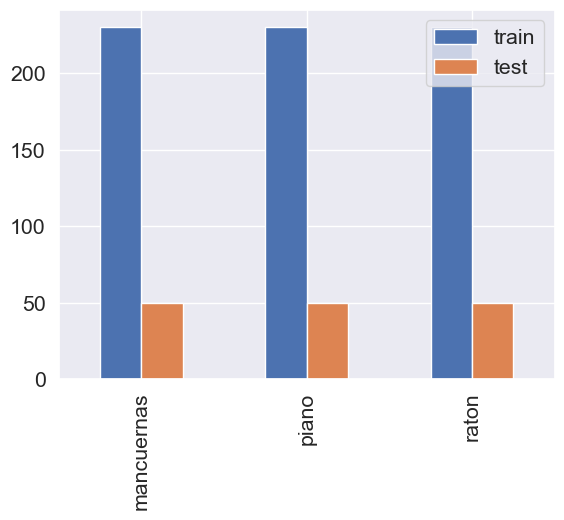

In [29]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

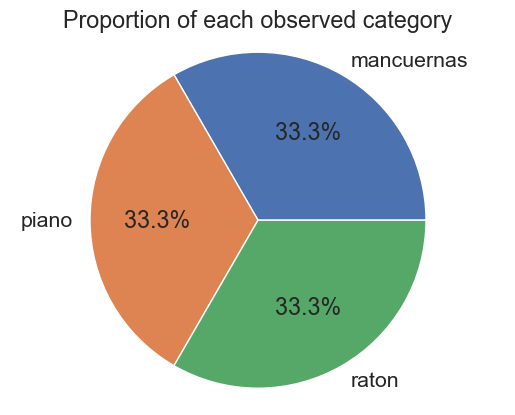

In [30]:
plt.pie(train_counts,
        explode=(0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [31]:
train_images = train_images / 255.0 
test_images = test_images / 255.0


In [32]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

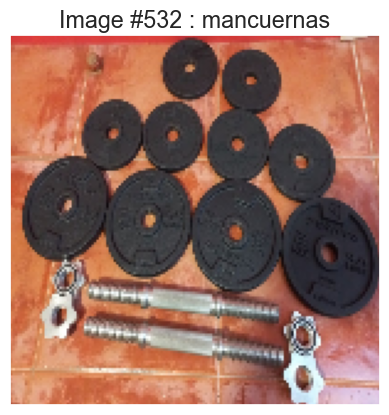

In [33]:
display_random_image(class_names, train_images, train_labels)


In [34]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

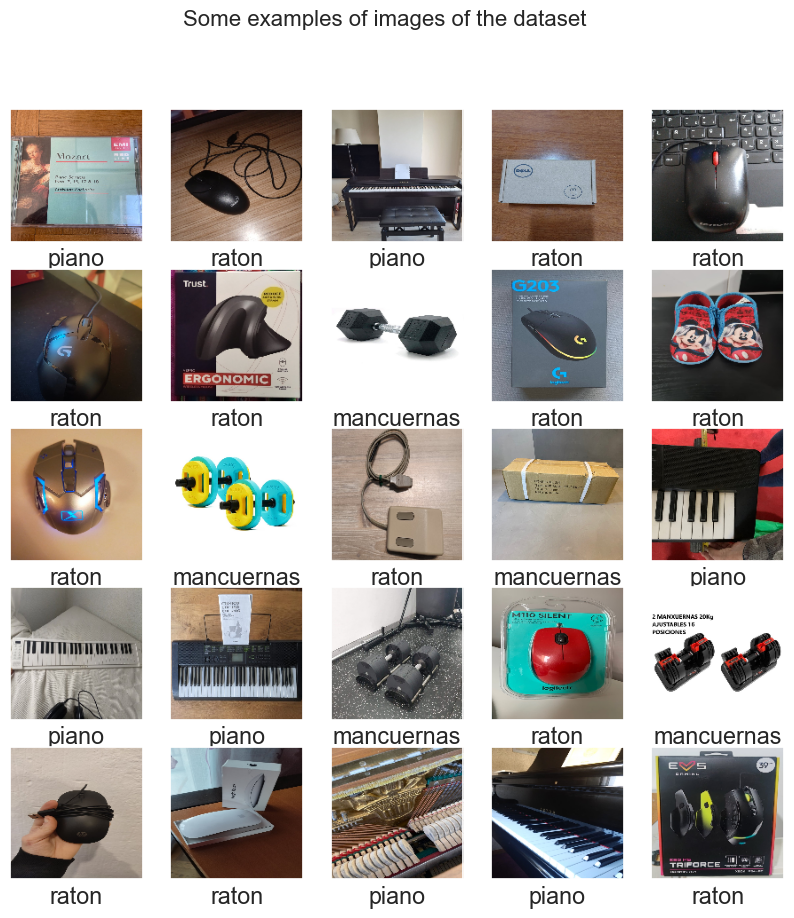

In [35]:
display_examples(class_names, train_images, train_labels)


In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [37]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
5/5 [==============================] - 10s 2s/step - loss: 5.0819 - accuracy: 0.3116 - val_loss: 3.2081 - val_accuracy: 0.3623
Epoch 2/20
5/5 [==============================] - 9s 2s/step - loss: 2.0994 - accuracy: 0.3351 - val_loss: 1.1683 - val_accuracy: 0.3551
Epoch 3/20
5/5 [==============================] - 8s 1s/step - loss: 1.2493 - accuracy: 0.3279 - val_loss: 1.3336 - val_accuracy: 0.3406
Epoch 4/20
5/5 [==============================] - 7s 1s/step - loss: 1.2147 - accuracy: 0.3605 - val_loss: 1.0965 - val_accuracy: 0.3696
Epoch 5/20
5/5 [==============================] - 7s 1s/step - loss: 1.0337 - accuracy: 0.4638 - val_loss: 1.1436 - val_accuracy: 0.3986
Epoch 6/20
5/5 [==============================] - 7s 1s/step - loss: 0.9360 - accuracy: 0.6105 - val_loss: 1.0212 - val_accuracy: 0.4928
Epoch 7/20
5/5 [==============================] - 6s 1s/step - loss: 0.8367 - accuracy: 0.6630 - val_loss: 0.9903 - val_accuracy: 0.5652
Epoch 8/20
5/5 [========================

In [39]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [40]:
test_loss = model.evaluate(test_images, test_labels)


5/5 [==============================] - 0s 69ms/step - loss: 1.5692 - accuracy: 0.4800


5/5 [==============================] - 0s 67ms/step


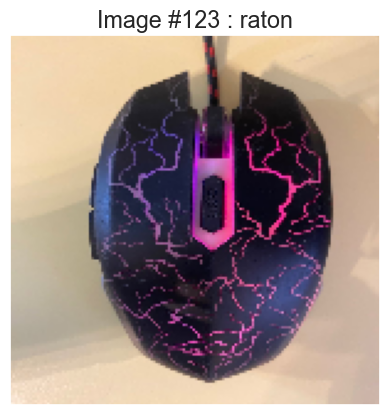

In [41]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [42]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

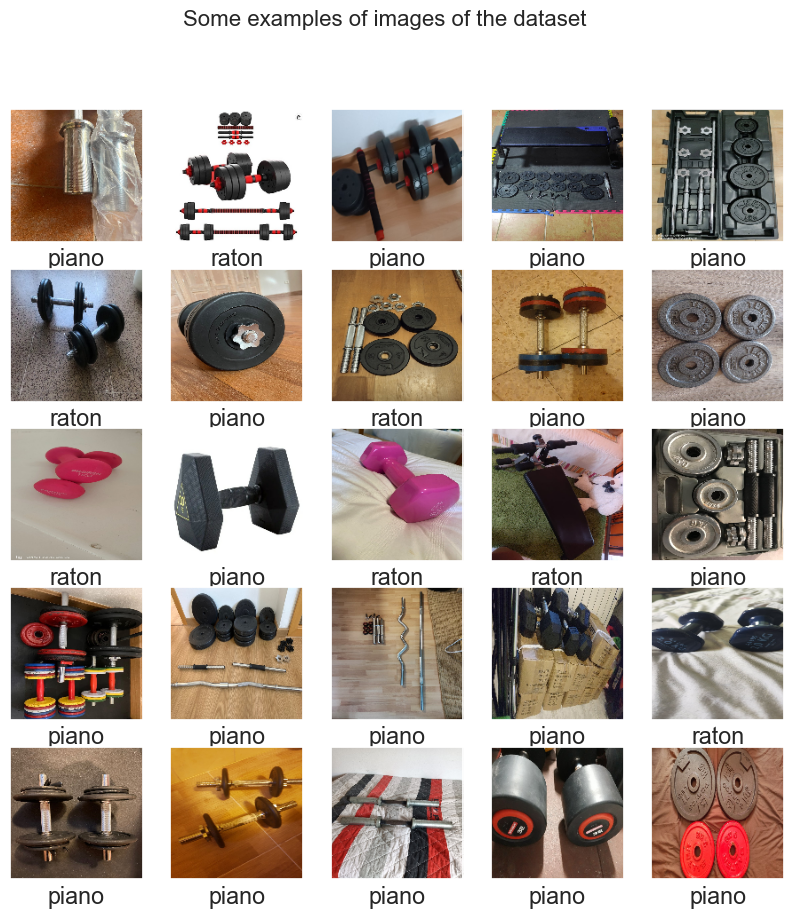

In [43]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)


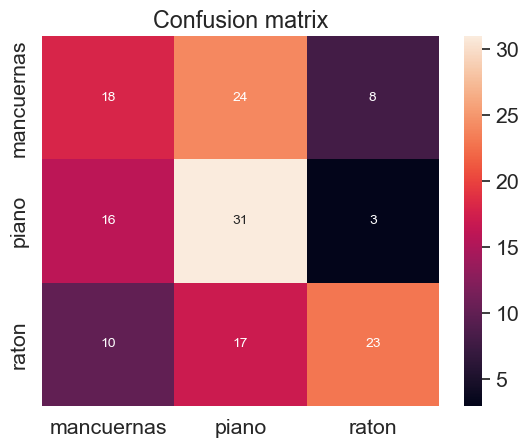

In [44]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [45]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

In [46]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

5/5 [==============================] - 8s 2s/step


In [47]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [48]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 3)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) 
C1 = C[:,0]
C2 = C[:,1]
C3 = C[:,2]

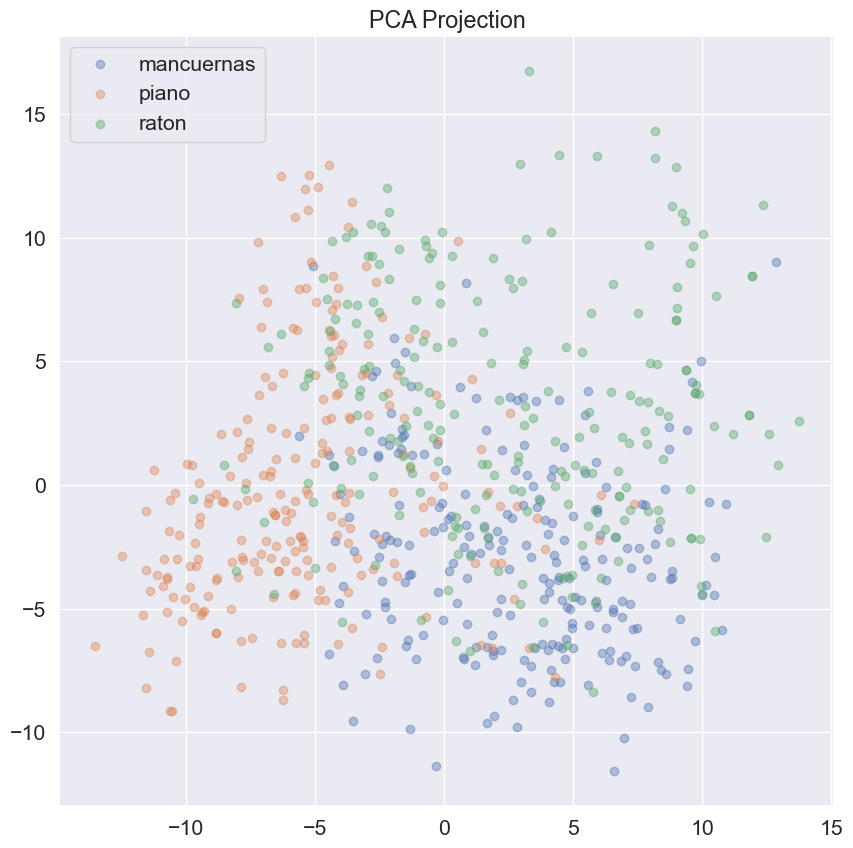

In [49]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

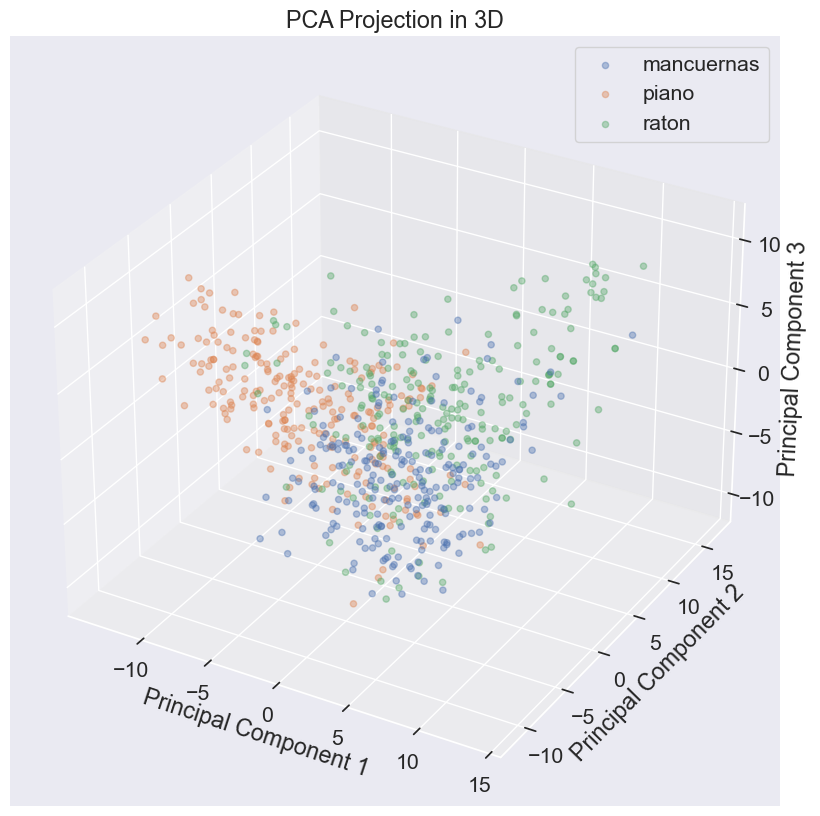

In [50]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i, class_name in enumerate(class_names):
    ax.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], C3[train_labels == i][:1000], label=class_name, alpha=0.4)
    
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.title("PCA Projection in 3D")
plt.show()


In [51]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
5/5 [==============================] - 1s 57ms/step - loss: 1.3006 - accuracy: 0.3895 - val_loss: 0.7205 - val_accuracy: 0.6884
Epoch 2/15
5/5 [==============================] - 0s 20ms/step - loss: 0.5430 - accuracy: 0.7826 - val_loss: 0.5647 - val_accuracy: 0.7681
Epoch 3/15
5/5 [==============================] - 0s 19ms/step - loss: 0.4002 - accuracy: 0.8551 - val_loss: 0.6100 - val_accuracy: 0.7754
Epoch 4/15
5/5 [==============================] - 0s 19ms/step - loss: 0.2752 - accuracy: 0.8967 - val_loss: 0.5236 - val_accuracy: 0.8043
Epoch 5/15
5/5 [==============================] - 0s 19ms/step - loss: 0.2137 - accuracy: 0.9275 - val_loss: 0.5237 - val_accuracy: 0.7754
Epoch 6/15
5/5 [==============================] - 0s 19ms/step - loss: 0.1489 - accuracy: 0.9620 - val_loss: 0.5100 - val_accuracy: 0.8188
Epoch 7/15
5/5 [==============================] - 0s 18ms/step - loss: 0.1087 - accuracy: 0.9801 - val_loss: 0.5192 - val_accuracy: 0.7681
Epoch 8/15
5/5 [===========

In [52]:
test_loss = model2.evaluate(test_features, test_labels)

5/5 [==============================] - 0s 4ms/step - loss: 0.4781 - accuracy: 0.8200


In [53]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

In [54]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [55]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
4/4 [==============================] - 1s 75ms/step - loss: 1.3651 - accuracy: 0.3770 - val_loss: 0.6337 - val_accuracy: 0.7321
Epoch 2/10
4/4 [==============================] - 0s 24ms/step - loss: 0.6665 - accuracy: 0.7117 - val_loss: 0.7404 - val_accuracy: 0.5536
Epoch 3/10
4/4 [==============================] - 0s 24ms/step - loss: 0.4058 - accuracy: 0.8306 - val_loss: 0.4470 - val_accuracy: 0.8036
Epoch 4/10
4/4 [==============================] - 0s 22ms/step - loss: 0.3086 - accuracy: 0.8690 - val_loss: 0.3790 - val_accuracy: 0.8929
Epoch 5/10
4/4 [==============================] - 0s 22ms/step - loss: 0.2057 - accuracy: 0.9496 - val_loss: 0.3794 - val_accuracy: 0.8571
Epoch 6/10
4/4 [==============================] - 0s 21ms/step - loss: 0.1362 - accuracy: 0.9617 - val_loss: 0.3134 - val_accuracy: 0.8214
Epoch 7/10
4/4 [==============================] - 0s 22ms/step - loss: 0.1032 - accuracy: 0.9758 - val_loss: 0.2816 - val_accuracy: 0.8571
Epoch 8/10
4/4 [===========

In [56]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

5/5 [==============================] - 0s 3ms/step


In [57]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.84
